import modules

In [6]:
import sys

sys.path.insert(0, "../abc")
import torch as t
from torch.distributions import uniform, normal
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from model import init_grids, model
from vis_utils import visualize_batch, visualize_sequence
from utils import chop_and_shuffle_data, heaviside, pre_process
from likelihoods import spread_likelihood, transition_likelihood, neg_log_likelihood
from distance_funcs import mean_sq_distance
from helpers import gaussian_pdf
from math import factorial
import time
from IPython.display import Image
from IPython import display
from tqdm import tqdm

# Experiment 4: Using Straight-through gradient estimation

## 1. Define the model functions

Straight-through estimator 

In [2]:
class STEFunction(t.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        return (input > 0).float()

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output

differentiable model using the STE function

In [3]:
def model_STE(grids: t.Tensor, beta: t.Tensor) -> t.Tensor:
    # produces a mask that is 1 for all healthy cells, 0 for the infected cells
    healthy_mask = 1 - grids
    # calculate the likelihood of spread 
    likelihoods = spread_likelihood(grids, beta)
    # compare each likelihood to a random value ~ U(0,1) to get the residual values
    if grids.is_cuda:
        residuals = likelihoods - t.rand(*grids.shape).cuda()
    else:
        residuals = likelihoods - t.rand(*grids.shape)
    # apply the heaviside to the residuals,
    #   if the residual is positive, the cell should be infected ( < spread_likelihood)
    #   if the residual is negative, the cell should stay healthy ( > spread_likelihood)
    #   if the cell was already infected, no update should be applied 
    update_mask = STEFunction.apply(residuals) * healthy_mask
    # apply the update to the current state
    return grids + update_mask

## 2. Dataset generated with a single $\beta$ value

### generate dataset

in this case, we can use the same model for generating the observations as for training. The two are equivalent in regards to the forward pass of the data

In [4]:
grid_size = 30
batch_size = 200
steps_per_sequence = 25
beta = t.tensor(0.2)

framerate = 0.2

In [5]:
print(f"generate dataset with beta={beta}")
sequences = t.zeros((batch_size, steps_per_sequence, grid_size, grid_size))
batch = init_grids(grid_size,batch_size)

for i in range(steps_per_sequence):
  sequences[:,i,:,:] = batch
  batch = model_STE(batch, beta)
  
dataset = chop_and_shuffle_data(sequences)
print(dataset.shape)

generate dataset with beta=0.20000000298023224
torch.Size([4800, 2, 30, 30])


### visualize example sequence

In [6]:
grids = init_grids(grid_size, 2)
for i in range(steps_per_sequence):
  visualize_batch(grids)
  display.display(plt.gcf())
  grids = model(grids, beta)
  display.clear_output(wait=True)
  time.sleep(framerate)

<Figure size 640x480 with 0 Axes>

### pre-process the dataset

In [7]:
dataset = pre_process(dataset)

remove 0 entries from the dataset
torch.Size([4800, 2, 30, 30])


### visualize the gradient of the distance function w.r.t. $\beta$ for $\beta=[0,1]$

In [8]:
betas = t.linspace(0.0, 1.0, 1000)
betas = betas.cuda()
X = dataset[:,0]
X = X.cuda()
Y_obs = dataset[:,1]
Y_obs = Y_obs.cuda()
grads = []
for beta in tqdm(betas):
    beta.requires_grad_()
    Y_sim = model_STE(X, beta)
    dist = mean_sq_distance(X, Y_sim, Y_obs)
    gradient = t.autograd.grad(dist, beta)[0]
    grads.append(gradient.detach().clone())

100%|██████████| 1000/1000 [02:31<00:00,  6.61it/s]


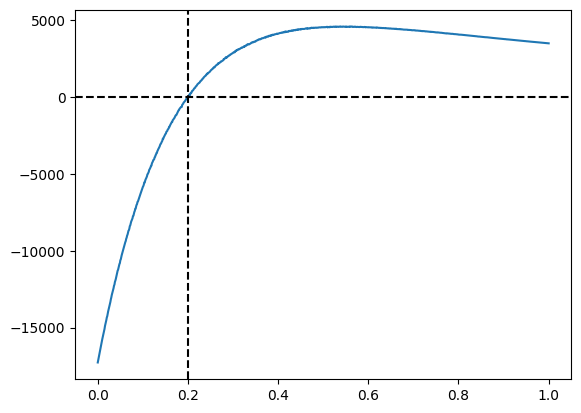

In [10]:
plt.plot(betas.cpu(), t.tensor(grads).cpu())
plt.axhline(y = 0., color = 'black', linestyle = '--')
plt.axvline(x = 0.2, color = 'black', linestyle = '--')

### define update & training functions

In [17]:
def update(
    beta: t.Tensor, X: t.Tensor, Y_obs: t.Tensor, learning_rate: float
) -> t.Tensor:
    beta.requires_grad_()
    Y_sim = model_STE(X, beta)
    dist = mean_sq_distance(X, Y_sim, Y_obs)
    gradient = t.autograd.grad(dist, beta)[0]
    return beta - learning_rate * gradient, gradient

def train(beta: t.Tensor, X: t.Tensor, Y_obs: t.Tensor, lr:float, num_steps:int):
    beta_hist = []
    grad_hist = []
    X = X.cuda()
    Y_obs = Y_obs.cuda()
    beta = beta.cuda()
    for i in tqdm(range(num_steps)):
        beta, gradient = update(beta, X, Y_obs, lr)
        beta_hist.append(beta.detach().clone())
        grad_hist.append(gradient.detach().clone())
    return beta, beta_hist, grad_hist

### run the training process

In [16]:
X = dataset[:, 0]
Y_obs = dataset[:, 1]
beta_init = uniform.Uniform(t.tensor(0.), t.tensor(1.)).sample()
lr = 1e-7
num_steps = 5_000

beta, beta_hist, grad_hist = train(beta_init, X, Y_obs, lr, num_steps)

100%|██████████| 5000/5000 [04:54<00:00, 16.99it/s]


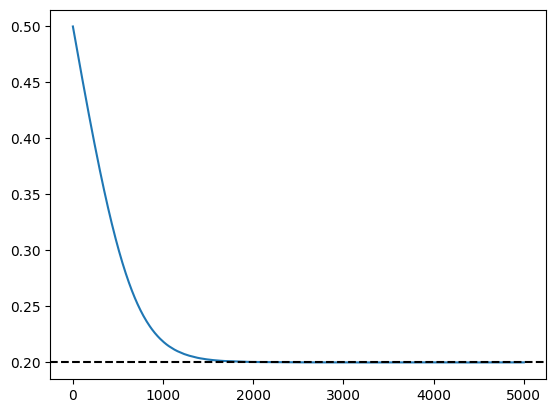

In [18]:
plt.plot(np.arange(len(beta_hist)), t.tensor(beta_hist))
plt.axhline(y = 0.2, color = 'black', linestyle = '--')
plt.show()

## 2. Dataset generated from a distribution of $\beta$ values

### define hyperparameters

In [20]:
grid_size = 30 
num_sequences = 500
steps_per_sequence = 15 
mu = t.tensor(0.5) 
sigma = t.tensor(0.1) 

frame_speed = 0.1 

### visualize distribution over $\beta$

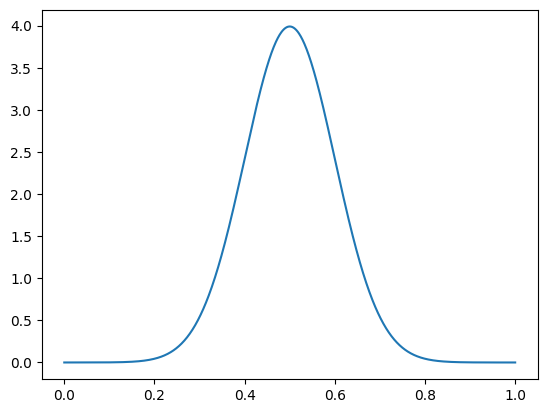

In [21]:
beta_pdf = gaussian_pdf(mu, sigma**2)

x_vis = t.linspace(0,1,1_000)
y_vis = beta_pdf(x_vis)

plt.plot(x_vis, y_vis)

### generate dataset

For the experiment, we generate 500 sequences of 15 CA steps respectively. At every step, $\beta$ is randomly sampled.

In [22]:
sequences = t.zeros((num_sequences, steps_per_sequence, grid_size, grid_size))
betas = []

# @title generate dataset
for seq_idx in tqdm(range(num_sequences)):
  sequence = init_grids(grid_size,1)
  for step_idx in range(steps_per_sequence):
    beta = t.clip(normal.Normal(mu, sigma).sample(), 0, 1)
    sequences[seq_idx,step_idx,:,:] = sequence
    sequence = model_STE(sequence, beta)
  betas.append(beta.detach())

dataset = chop_and_shuffle_data(sequences)

100%|██████████| 500/500 [00:05<00:00, 97.34it/s] 


### visualize empirical distribution over $\beta$

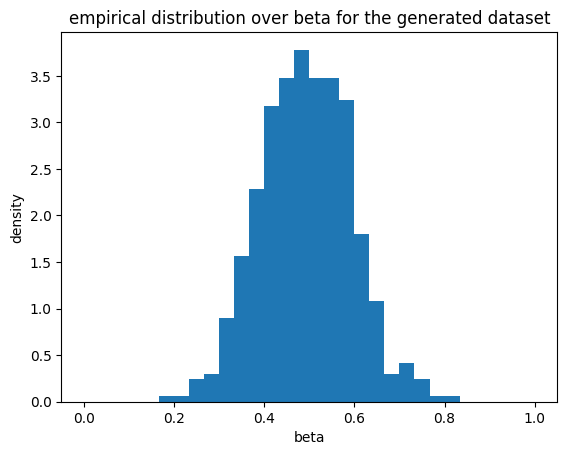

tensor(0.4929)


In [23]:
plt.hist(betas, density=True, range=(0,1), bins=30)
plt.title("empirical distribution over beta for the generated dataset")
plt.xlabel("beta")
plt.ylabel("density")
plt.show()
print(t.mean(t.tensor(betas)))

### pre-process the dataset

In [24]:
dataset = pre_process(dataset)

remove 0 entries from the dataset
torch.Size([7000, 2, 30, 30])


### run training

In [25]:
X = dataset[:, 0]
Y_obs = dataset[:, 1]
beta_init = uniform.Uniform(t.tensor(0.), t.tensor(1.)).sample()
lr = 1e-7
num_steps = 15_000

beta, beta_hist, grad_hist = train(beta_init, X, Y_obs, lr, num_steps)

100%|██████████| 15000/15000 [39:31<00:00,  6.33it/s] 


In [28]:
import os
np.save(os.path.join(os.getcwd(), "betas.npy"), t.tensor(beta_hist).cpu().numpy())
np.save(os.path.join(os.getcwd(), "gradients.npy"), t.tensor(grad_hist).cpu().numpy())

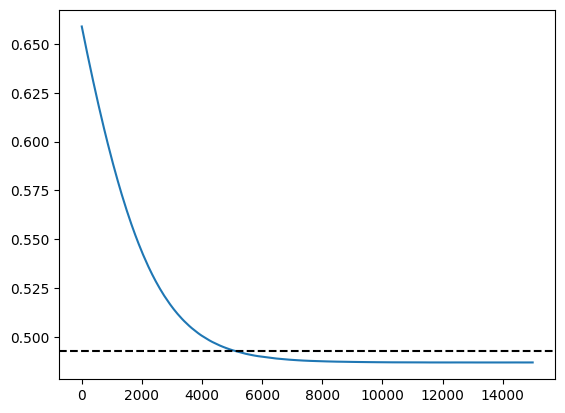

In [31]:
plt.plot(np.arange(len(beta_hist)), t.tensor(beta_hist))
plt.axhline(y = 0.4929, color = 'black', linestyle = '--')
plt.show()

In [30]:
print(beta)

tensor(0.4868, device='cuda:0', grad_fn=<SubBackward0>)


### compare to the actual likelihoods

In [32]:
betas = t.linspace(0.0, 1.0, 1000)
betas = betas.cuda()
X = dataset[:,0]
X = X.cuda()
Y_obs = dataset[:,1]
Y_obs = Y_obs.cuda()
likelihoods = []
for beta in tqdm(betas):
    beta.requires_grad_()
    L = spread_likelihood(X, beta)
    P = transition_likelihood(L, X, Y_obs)
    likelihood = neg_log_likelihood(P)
    likelihoods.append(likelihood.detach().clone().cpu())

100%|██████████| 100/100 [00:02<00:00, 45.52it/s]


tensor(0.4848, device='cuda:0')


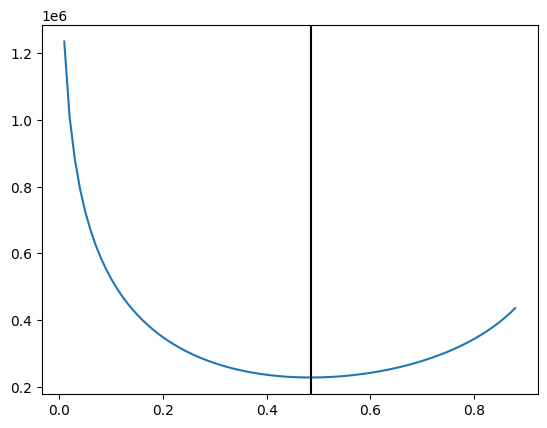

In [38]:
plt.plot(betas.cpu(), t.tensor(likelihoods))
min_l = min(likelihoods)
print(betas[likelihoods.index(min_l)])
plt.axvline(x=betas[likelihoods.index(min_l)].cpu(), color='black')